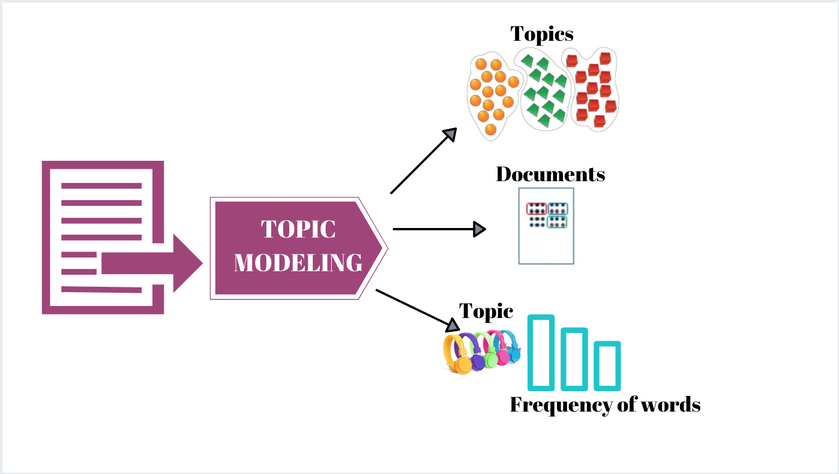

# Topic Modeling

En el ámbito machine learning y el procesamiento del lenguaje natural (NLP), topic modeling es **un tipo de modelo estadístico para descubrir los temas o tópicos abstractos que aparecen en una colección de documentos**.


Es una herramienta de **minería de textos** muy utilizada para descubrir estructuras semánticas en los textos. Intuitivamente, dado que un documento trata de un tema concreto, cabe esperar que determinadas palabras aparezcan en el documento con mayor o menor frecuencia.

Un documento suele referirse a varios temas en diferentes proporciones; así, en un documento que trata un 10% de economía y un 90% de política, probablemente habrá unas 9 veces más palabras de política que de economía. Los tópicos producidos por las técnicas de modelización temática son grupos de palabras similares. **Un modelo temático recoge esta intuición en un marco matemático**, que permite analizar documentos y descubrir, basándose en las estadísticas de las palabras de cada uno, cuáles podrían ser los **temas** y cuál es la **proporción de temas de cada documento**.

Entonces, en resumen, **topic Modeling** es el **proceso de analizar grandes volúmenes de texto para clusterizarlos en tópicos**. Se trata de un proceso de **machine learning no supervisado** en el que el algoritmo detecta temas comunes en el corpus y los agrupa.

Un punto importante a aclarar en esta área de NLP es entender que, al tratarse de aprendizaje no supervisado y por ende no tener una feature objetivo, **no tenemos realmente el tópico correcto**. Sólo sabemos que los textos tienen temas en común, pero **depende del usuario identificar el tema en sí**.

*****

## Librerías

Para esta demo, vamos a usar varias librerías distintas que se involucran en el proceso de obtención, limpieza y procesamiento de datos.

* **Pandas**: La utilizaremos para crear el objeto DataFrame y modificarlo hasta tener los datos que necesitamos. Luego le agregaremos información sobre los tópicos para las visualizaciones.
* **Tweepy**: Librería especialmente diseñada para interactuar con la API de Twitter, la usaremos para scrapear los tweets de las cuentas de interés.
* **Re**: Módulo de expresiones regulares de Python, muy utilizada en muchas de las tareas de NLP.
* **Matplotlib y Seaborn**: Utilizadas para visualizaciones de los resultados del topic modeling.
* **NLTK y spaCy**: de la primera librería utilizaremos únicamente el listado de stop words, de la segunda necesitaremos componentes del pipeline y algunas POS tags.

In [1]:
# Pandas
import pandas as pd

# Tweepy
import tweepy
from tweepy import OAuthHandler
from tweepy import Cursor

# RegEx
import re

# Matplotlib y Seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías NLP
from nltk.corpus import stopwords
import spacy

# Librerías adicionales para visualización
import numpy as np
from PIL import Image
from wordcloud import WordCloud

## Funciones

En este trabajo, utilizaremos tres funciones custom que nos serán útiles en dos pasos claves del proceso: obtención y limpieza de datos.

In [2]:
def cleaner(word):
    
    '''Función que toma un texto y remueve distintos símbolos y variaciones de palabras.
    Devuelve el string limpio.
    '''
    
    word = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', 
                  '', word, flags=re.MULTILINE) 
    word = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', "", word) #remueve interrogación, paréntesis, dos puntos, etc
    word = re.sub(r'ee.uu', 'eeuu', word) #convierte todas las variaciones de EEUU sin importar el separador en EEUU 
    word = re.sub(r'\#\.', '', word)
    word = re.sub(r'\n', '', word) #remueve todos los line-breaks
    word = re.sub(r',', '', word) #remueve comas
    word = re.sub(r'\-', ' ', word) #remueve guiones
    word = re.sub(r'\.{3}', ' ', word) #remueve tres puntos
    word = re.sub(r'a{2,}', 'a', word) #remueve múltiples instancias de la letra a (p.ej: aaaaaaah, holaaaaaa)
    word = re.sub(r'é{2,}', 'é', word) #remueve múltiples instancias de la letra é (p.ej: volvééééé)
    word = re.sub(r'i{2,}', 'i', word) #remueve múltiples instancias de la letra i (p.ej: salíiiiiii)
    word = re.sub(r'ja{2,}', 'ja', word) #remueve las "risas" (p.ej: jaaaaaa)
    word = re.sub(r'á', 'a', word) #remueve las tildes de las a
    word = re.sub(r'é', 'e', word) #remueve las tildes de las e
    word = re.sub(r'í', 'i', word) #remueve las tildes de las i
    word = re.sub(r'ó', 'o', word) #remueve las tildes de las o
    word = re.sub(r'ú', 'u', word) #remueve las tildes de las u
    word = re.sub('[^a-zA-Z]', ' ', word) #remueve todos los símboloso no alfabéticos
    
    return word

In [3]:
def postags_and_stopwords(texts, allowed_postags=['NOUN', 'ADJ','PROPN', 'X']):
    '''Función que procesa todos los textos en un pipeline de spaCy para tokenizar y etiquetar las POS.
    Luego, filtra todas las palabras de longitud mayor a 2 caracteres que no sean stop words y que se encuentren
    dentro de las etiquetas permitidas: sustantivo, adjetivo, nombre propio y todo lo que no caiga en una categoría
    preestablecida (palabras OOV, nombres propios no reconocidos, etc).
    Devuelve los textos procesados.
    '''
    
    texts_out = ' '.join([token.text for token in nlp(texts) if token.pos_ in 
                 allowed_postags and token.text not in stop_words and len(token.text) > 2])
    return texts_out

In [4]:
def extract_timeline_as_df(timeline_list, num_tweets, exclude_replies=True, include_rts=False):
    
    '''Scrapeadora de timelines de Twitter y las convierte en un DataFrame para trabajar o exportar en un csv. 
    Toma cuatro parámetros:
    timeline_list: el nombre de la timeline a scrapear, sin @.
    num_tweets: la cantidad de tweets a scrapear.
    exclude_replies: si es True, no incluye respuestas del usuario. Si es False, las incluye. Default True.
    include_rts: si es True, incluye retweets que hizo el usuario. Si es False, no los incluye. Default False.
    Devuelve el objeto DataFrame
    '''
    
    columns = set()
    allowed_types = [str, int]
    tweets_data = []
    for i, status in enumerate(tweepy.Cursor(api.user_timeline, screen_name=timeline_list, exclude_replies=exclude_replies, 
                                             include_rts=include_rts, tweet_mode='extended'
                                            ).items(num_tweets)):
        status_dict = dict(vars(status))
        keys = status_dict.keys()
        single_tweet_data = {'date': status.created_at, 'user': status.user.screen_name, 'author': status.author.screen_name}
        for k in keys:
            try:
                v_type = type(status_dict[k])
            except:
                v_type = None
            if v_type != None:
                if v_type in allowed_types:
                    single_tweet_data[k] = status_dict[k]
                    columns.add(k)
        tweets_data.append(single_tweet_data)
        
    allowed_cols = ['full_text', 'user', 'date']
    header_cols = list(columns)
    header_cols.append('date')
    header_cols.append('user')
    header_cols = [col_name for col_name in header_cols if col_name in allowed_cols]
    df = pd.DataFrame(tweets_data, columns=header_cols)
    return df

## Credenciales de Twitter

Para poder interactuar con la API de Twitter, además de la librería Tweepy, necesitaremos **credenciales de acceso** para el desarrollo de aplicaciones que utilicen datos de la plataforma. Estas credenciales se obtienen mediante la solicitud de una **cuenta de desarrollador de Twitter**.

El proceso de solicitud es bastante simple y suele ser aprobado en poco tiempo. Los pasos a seguir los encuentran en el siguiente tutorial de YouTube (*aviso parroquial: el tutorial está en inglés*): https://www.youtube.com/watch?v=vlvtqp44xoQ

In [5]:
# Credenciales de Twitter (se obtienen solicitando una cuenta de desarrollador)
consumer_key = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
consumer_secret = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
access_key = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
access_secret = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'

# Le pasamos nuestras credenciales al OAuthHandler para acceder a la API
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

## Creación del DataFrame

Mediante nuestra función `extract_timeline_as_df`, indicamos los parámetros para scrapear y crear la base de datos que usaremos para nuestro modelado de tópicos. En este caso, vamos a utilizar datos de la cuenta de Clarín en Twitter ('clarincom') e indicar la cantidad de tweets que queremos en nuestro DataFrame (2000 en el ejemplo). Además, dejamos la fecha por si queremos agregar un paso de procesamiento adicional de filtrado entre fechas y el usuario para corroborar que la cuenta de la que obtuvimos los tweets es la correcta.

In [6]:
# Creamos el DataFrame con nuestra función custom

df = extract_timeline_as_df(timeline_list='clarincom', num_tweets=2000)

In [7]:
# Observamos nuestro DataFrame

df

,full_text,date,user
0,El retiro de Seba Nerone: 'No me quedó una got...,2021-11-24 18:14:12,clarincom
1,Ángel Di María le regaló su camiseta autografi...,2021-11-24 18:08:16,clarincom
2,Se hicieron selfies con los cadáveres de dos h...,2021-11-24 18:05:03,clarincom
3,Se conoció una fuerte frase sexual que la Chin...,2021-11-24 18:03:05,clarincom
4,Chocó en moto con un conductor alcoholizado y ...,2021-11-24 18:03:04,clarincom
...,...,...,...
1995,'No quiero niños en mi boda': novia fue critic...,2021-11-15 15:13:51,clarincom
1996,FMI: cinco claves del anuncio y promesa de Alb...,2021-11-15 15:08:25,clarincom
1997,"Lagos del Furioso, un sueño familiar que invit...",2021-11-15 15:07:00,clarincom
1998,Llegó la cubana Mavys Álvarez a la Argentina p...,2021-11-15 14:54:07,clarincom


In [8]:
# Leemos el primer tweet para ver el formato y contenido

df['full_text'][0]

"El retiro de Seba Nerone: 'No me quedó una gota de sudor por dar' https://t.co/QaJKAAtszS"

### Limpieza del texto

Obtenidos los datos para nuestro topic modeling, procedemos con su **limpieza para llevarlos a un formato adecuado**. Estos pasos son: **remover stop words** que no aportan significado, **quitar puntuación** (puntos, comas, tildes y demás) y **quedarnos con las categorías de palabras que nos interesan**. Para esta demo, nos vamos a enfocar más en sustantivos, nombres propios, adjetivos y palabras que no caen en otras categorías (palabras que spaCy en español no reconoce como NBA, por ejemplo), sin incluir verbos.

Se podrían dejar los verbos dependiendo del tipo de análisis que queramos hacer. En este caso, los dejamos afuera para tener tópicos más "compactos", pero también se podría analizar cuáles son los verbos que más usa Clarín. ¡Pueden modificar la función `postags_and_stopwords` y agregar o remover POS tags que quieran incluir en sus análisis personales!

In [9]:
# Asignamos la lista de stop words a una variable

stop_words = stopwords.words('spanish')

type(stop_words)

list

In [10]:
# Removemos las stop words y creamos una nueva columna para los textos procesados

df['full_text_clean'] = df['full_text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop_words)]))

In [12]:
# Comparamos los textos con y sin stop words

df['full_text'][0], df['full_text_clean'][0]

("El retiro de Seba Nerone: 'No me quedó una gota de sudor por dar' https://t.co/QaJKAAtszS",
 "retiro Seba Nerone: 'No quedó gota sudor dar' https://t.co/QaJKAAtszS")

In [13]:
# Creamos el pipeline de procesamiento de spaCy con el modelo en español para poder utilizar nuestra función cleaner

nlp = spacy.load('es_core_news_md')

In [14]:
# Aplicamos la función cleaner a todo el texto

df['full_text_clean'] = df['full_text_clean'].apply(cleaner)

In [15]:
# Comparamos los textos luego de aplicar la función cleaner

df['full_text'][0], df['full_text_clean'][0]

("El retiro de Seba Nerone: 'No me quedó una gota de sudor por dar' https://t.co/QaJKAAtszS",
 'retiro Seba Nerone   No quedo gota sudor dar  ')

In [16]:
# Aplicamos la función postags_and_stopwords a todo el texto

df['full_text_clean'] = df['full_text_clean'].apply(postags_and_stopwords)

In [17]:
# Comparamos los textos luego de aplicar la función postags_and_stopwords

df['full_text'][0], df['full_text_clean'][0]

("El retiro de Seba Nerone: 'No me quedó una gota de sudor por dar' https://t.co/QaJKAAtszS",
 'retiro Seba Nerone gota sudor')

In [18]:
# Observamos el DataFrame con la nueva columna

df

,full_text,date,user,full_text_clean
0,El retiro de Seba Nerone: 'No me quedó una got...,2021-11-24 18:14:12,clarincom,retiro Seba Nerone gota sudor
1,Ángel Di María le regaló su camiseta autografi...,2021-11-24 18:08:16,clarincom,ngel Maria regalo camiseta autografiada Santi ...
2,Se hicieron selfies con los cadáveres de dos h...,2021-11-24 18:05:03,clarincom,selfies cadaveres hermanas asesinadas WhatsApp
3,Se conoció una fuerte frase sexual que la Chin...,2021-11-24 18:03:05,clarincom,fuerte frase sexual China Suarez enviado Mauro...
4,Chocó en moto con un conductor alcoholizado y ...,2021-11-24 18:03:04,clarincom,Choco moto conductor alcoholizado vida terapia...
...,...,...,...,...
1995,'No quiero niños en mi boda': novia fue critic...,2021-11-15 15:13:51,clarincom,boda novia criticada hijos casa
1996,FMI: cinco claves del anuncio y promesa de Alb...,2021-11-15 15:08:25,clarincom,FMI claves anuncio promesa Alberto Fernandez
1997,"Lagos del Furioso, un sueño familiar que invit...",2021-11-15 15:07:00,clarincom,Lagos Furioso sue familiar inmensidad Patagonia
1998,Llegó la cubana Mavys Álvarez a la Argentina p...,2021-11-15 14:54:07,clarincom,Llego cubana Mavys lvarez Argentina causa ento...


## Modelado de tópicos

Para esta demo, vamos a aplicar dos modelos con sus respectivos vectorizadores de preferencia:

**Latent Dirichlet Allocation** con **CountVectorizer** por un lado, y **Non-negative Matrix Factorization** con **TF-IFD** por otro. Luego, evaluaremos los distintos tópicos formulados por los modelos en base a qué tanto sentido tienen las agrupaciones de palabras.

### Latent Dirichlet Allocation

In [19]:
# Importamos el CountVectorizer y Latent Dirichlet Allocation de Scikit-Learn

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

#### Breve aclaración sobre el vectorizador

Una pregunta razonable sería "¿Por qué no aplicamos TF-IDF en vez de CountVectorizer para vectorizar los documentos?" Si bien la respuesta técnica escapa al enfoque de esta notebook, les dejo una cita traducida de uno de los autores del paper de presentación de Latent Dirichlet Allocation:

>*De hecho, Blei (que desarrolló el LDA), señala en la introducción del artículo de 2003 (titulado "Latent Dirichlet Allocation") que el LDA aborda las deficiencias del modelo TF-IDF y deja atrás este enfoque. LSA es completamente algebraico y generalmente (pero no necesariamente) utiliza una matriz TF-IDF, mientras que LDA es un modelo probabilístico que trata de estimar las distribuciones de probabilidad para los temas en los documentos y las palabras en los temas. La ponderación de TF-IDF no es necesaria para esto.*

In [20]:
# Creamos la instancia del CountVectorizer

cv = CountVectorizer(max_df=0.95, min_df=2)

#### Breve aclaración sobre los parámetros

En el CountVectorizer indicamos dos parámetros: `max_df` y `min_df`. La explicación de qué hacen es la siguiente:

`max_df` se usa para remover términos que aparecen demasiado frecuentemente, conocidas como "stop words específicas de dominio/corpus". Por ejemplo:

* `max_df`=0.5 significa "ignorá los términos que aparecen en más del 50% de los documentos.
* `max_df`=25 significa "ignorá los términos que aparecen en más de 25 documentos".
El parámetro por defecto es 1.0, que significa "ignorá los términos que aparecen en más del 100% de los documentos", por lo que no ignora ninguno.

`min_df` se utiliza para remover los términos que aparecen demasiado infrecuentemente. Por ejemplo:

* `min_df`=0.01 significa "ignorá los términos que aparecen en menos del 1% de los documentos.
* `min_df`=5 significa "ignorá los términos que aparecen en menos de 5 documentos.
El parámetro por defecto es 1, que significa "ignorá los términos que aparecen en menos de 1 documento", por lo que no ignora ninguno.

Es normal en este tipo de trabajos eliminar algunos de los términos demasiado frecuentes o infrecuentes para reducir el costo computacional, eliminar stop words que no hayan sido capturadas por la lista de NLTK o evitar las palabras demasiado frecuentes que homogenizan los tópicos.

Dicho esto, prosigamos.

In [21]:
# Fitteamos los datos al vectorizador

dtm = cv.fit_transform(df['full_text_clean'])

In [22]:
# Creamos una instancia de Latent Dirichlet Allocation e indicamos la cantidad de tópicos que queremos y una semilla

LDA = LatentDirichletAllocation(n_components=8, random_state=42)

In [23]:
# Fitteamos los datos al modelo

LDA.fit(dtm)

LatentDirichletAllocation(n_components=8, random_state=42)

In [24]:
# Obtenemos las 15 palabras más importantes de cada tópico

for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['oposicion', 'milei', 'javier', 'presidente', 'venezuela', 'kast', 'plan', 'primera', 'vida', 'alberto', 'fernandez', 'chile', 'elecciones', 'gobierno', 'mas']


THE TOP 15 WORDS FOR TOPIC #1
['conflicto', 'primera', 'interna', 'elecciones', 'mauro', 'icardi', 'brasil', 'final', 'qatar', 'seleccion', 'argentina', 'juntos', 'cambio', 'mundial', 'mas']


THE TOP 15 WORDS FOR TOPIC #2
['personas', 'familia', 'dia', 'brasil', 'san', 'fernandez', 'joven', 'juan', 'justicia', 'argentina', 'crimen', 'policias', 'gonzalez', 'mas', 'lucas']


THE TOP 15 WORDS FOR TOPIC #3
['gran', 'video', 'ultimo', 'qatar', 'messi', 'lunar', 'formula', 'paso', 'eclipse', 'wanda', 'nara', 'susana', 'gimenez', 'historia', 'mas']


THE TOP 15 WORDS FOR TOPIC #4
['novela', 'fecha', 'clarin', 'noviembre', 'auto', 'primera', 'millones', 'profesional', 'liga', 'dia', 'premio', 'minuto', 'mensaje', 'maradona', 'mas']


THE TOP 15 WORDS FOR TOPIC #5
['gobierno', 'video', 'covid', 'casos',

### Non-negative Matrix Factorization

In [25]:
# Importamos el vectorizador TF-IDF y Non-negative Matrix Factotization de Scikit-Learn

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [26]:
# Creamos la instancia del vectorizador

tfidf = TfidfVectorizer(max_df=0.95, min_df=2)

In [27]:
# Fitteamos los datos al vectorizador

dtm = tfidf.fit_transform(df['full_text_clean'])

In [28]:
# Obtenemos nuestra document term matrix

dtm

<2000x2143 sparse matrix of type '<class 'numpy.float64'>'
	with 10904 stored elements in Compressed Sparse Row format>

In [29]:
# Creamos una instancia de Non-negative Matrix Factorization e indicamos la cantidad de tópicos que queremos y una semilla

nmf_model = NMF(n_components=8, random_state=42)

In [30]:
# Fitteamos los datos al modelo

nmf_model.fit(dtm)

NMF(n_components=8, random_state=42)

In [31]:
# Transformamos los resultados

topic_results = nmf_model.transform(dtm)

In [32]:
# Vemos la distribución de probabilidades para el tópico 0 y la probabilidad más alta

topic_results[0], topic_results[0].argmax()

(array([0.00000000e+00, 2.26252129e-04, 0.00000000e+00, 0.00000000e+00,
        9.17813984e-05, 0.00000000e+00, 1.39384309e-03, 0.00000000e+00]), 6)

In [33]:
# Obtenemos las 15 palabras más importantes de cada tópico

for index, topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['familiares', 'hijo', 'marcha', 'justicia', 'detencion', 'amigos', 'familia', 'ciudad', 'acusados', 'barracas', 'asesinato', 'crimen', 'policias', 'gonzalez', 'lucas']


THE TOP 15 WORDS FOR TOPIC #1
['clasificacion', 'clasico', 'paul', 'fmi', 'empate', 'historia', 'partido', 'messi', 'seleccion', 'qatar', 'juan', 'san', 'mundial', 'brasil', 'argentina']


THE TOP 15 WORDS FOR TOPIC #2
['fmi', 'kirchner', 'malvinas', 'juez', 'electoral', 'anibal', 'bullrich', 'patricia', 'derrota', 'luis', 'discurso', 'acto', 'cristina', 'alberto', 'fernandez']


THE TOP 15 WORDS FOR TOPIC #3
['conflicto', 'descubrio', 'affaire', 'detalles', 'relacion', 'pelea', 'paris', 'gimenez', 'icardi', 'mauro', 'susana', 'suarez', 'china', 'nara', 'wanda']


THE TOP 15 WORDS FOR TOPIC #4
['defensa', 'feliz', 'luna', 'militante', 'militancia', 'conmemora', 'lunar', 'eclipse', 'importantes', 'temas', 'tapa', 'fecha', 'mensaje', 'noviembre', 'dia']


THE TOP 15 WORDS FOR TOPIC #5
['sit

In [34]:
# Creamos una columna para agregar el tópico al lado de cada texto

df['topic_nmf'] = topic_results.argmax(axis=1)

In [35]:
df

,full_text,date,user,full_text_clean,topic_nmf
0,El retiro de Seba Nerone: 'No me quedó una got...,2021-11-24 18:14:12,clarincom,retiro Seba Nerone gota sudor,6
1,Ángel Di María le regaló su camiseta autografi...,2021-11-24 18:08:16,clarincom,ngel Maria regalo camiseta autografiada Santi ...,6
2,Se hicieron selfies con los cadáveres de dos h...,2021-11-24 18:05:03,clarincom,selfies cadaveres hermanas asesinadas WhatsApp,6
3,Se conoció una fuerte frase sexual que la Chin...,2021-11-24 18:03:05,clarincom,fuerte frase sexual China Suarez enviado Mauro...,3
4,Chocó en moto con un conductor alcoholizado y ...,2021-11-24 18:03:04,clarincom,Choco moto conductor alcoholizado vida terapia...,6
...,...,...,...,...,...
1995,'No quiero niños en mi boda': novia fue critic...,2021-11-15 15:13:51,clarincom,boda novia criticada hijos casa,3
1996,FMI: cinco claves del anuncio y promesa de Alb...,2021-11-15 15:08:25,clarincom,FMI claves anuncio promesa Alberto Fernandez,2
1997,"Lagos del Furioso, un sueño familiar que invit...",2021-11-15 15:07:00,clarincom,Lagos Furioso sue familiar inmensidad Patagonia,1
1998,Llegó la cubana Mavys Álvarez a la Argentina p...,2021-11-15 14:54:07,clarincom,Llego cubana Mavys lvarez Argentina causa ento...,1


## Visualizaciones

Definidos ya los tópicos, podemos crear algunas visualizaciones que nos den un panorama más claro de nuestros resultados. Veamos algunos ejemplos posibles.

Text(0.5, 1.0, 'Porcentaje de cada tópico')

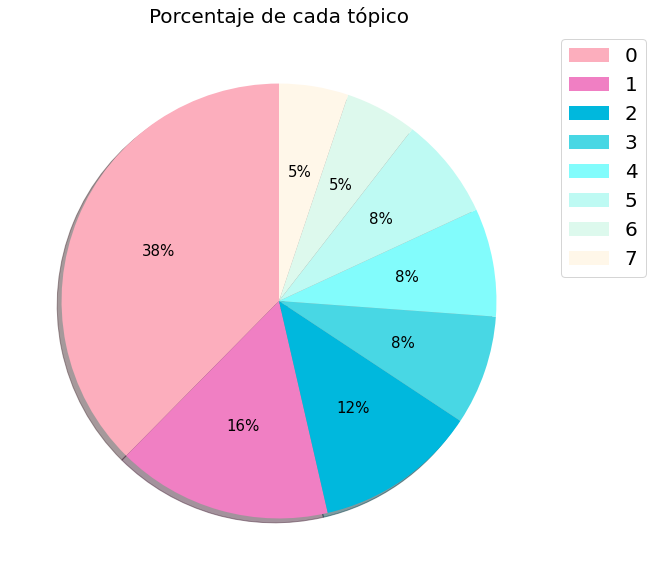

In [36]:
# Pie chart

colors = ["#fcaebd", "#f07fc3", "#00b8dd", "#48d7e4", "#82fcfc", "#befaf3", "#ddf9ed", "#fff7e9", "#fcf1cd", "#faedb1","#00b8dd", "#48d7e4"]

f = plt.figure(figsize=(10,10))
plt.pie(df['topic_nmf'].value_counts(), autopct='%1.f%%', shadow=True, startangle=90, textprops={"size":15}, colors=colors)

plt.ylabel('')

values_pie = df.index.to_list()
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', labels=values_pie, prop={"size":20})

plt.title("Porcentaje de cada tópico", size=20)

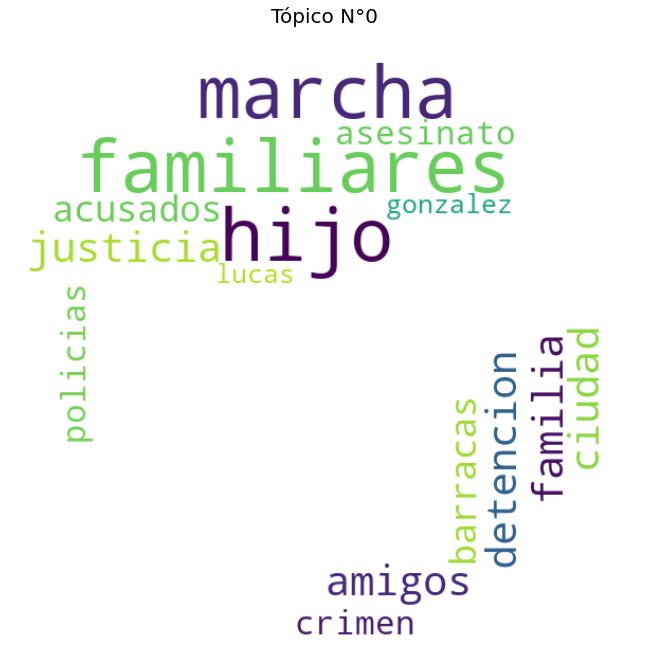

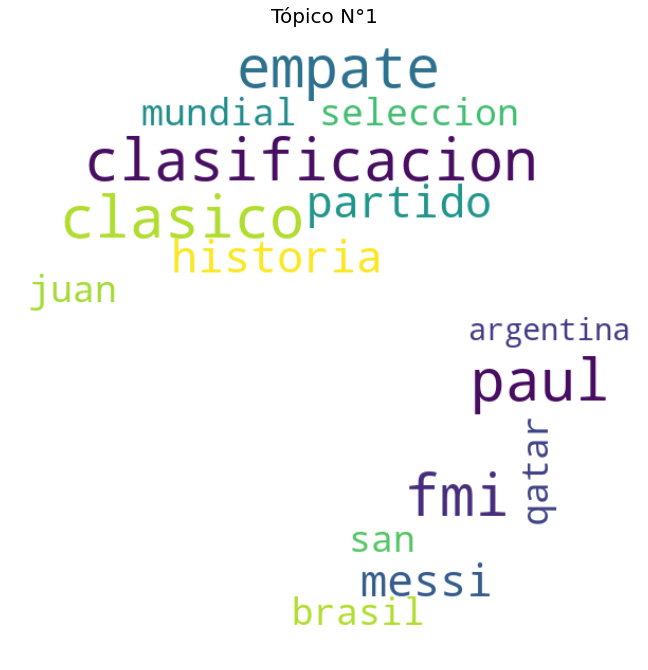

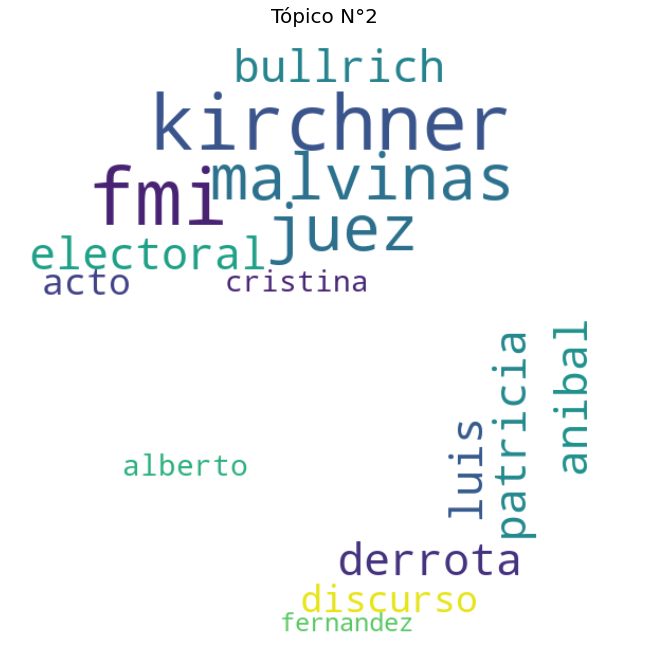

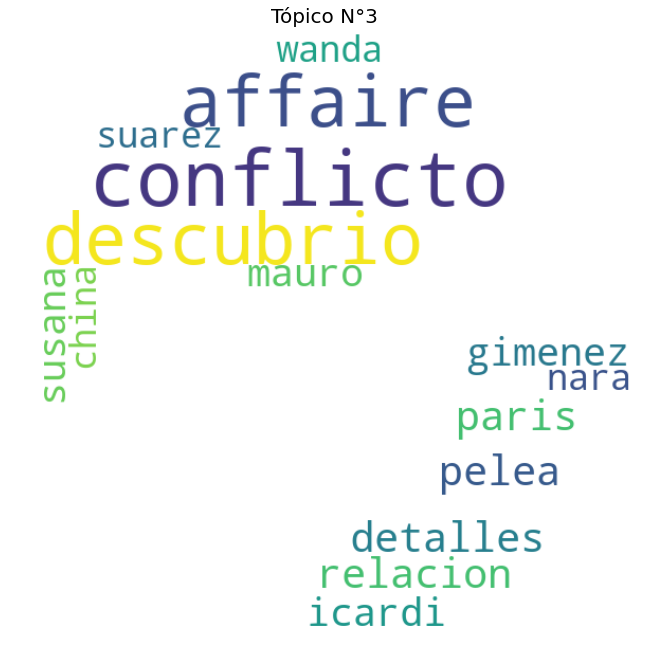

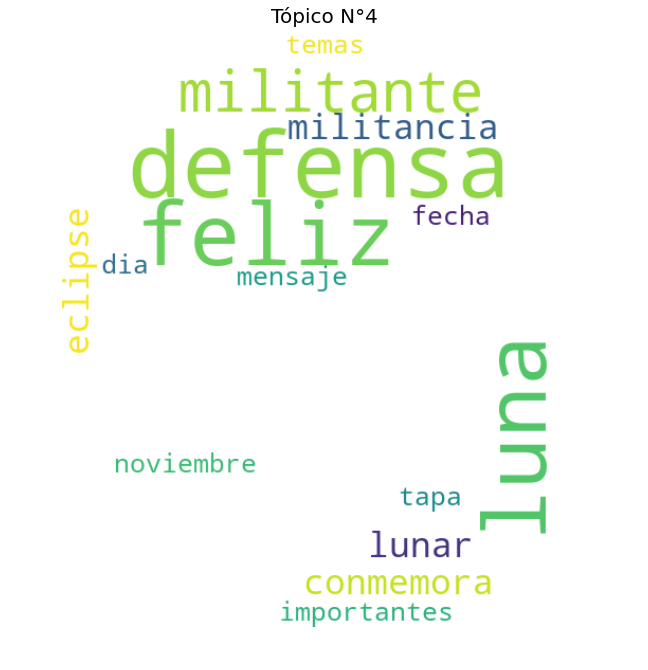

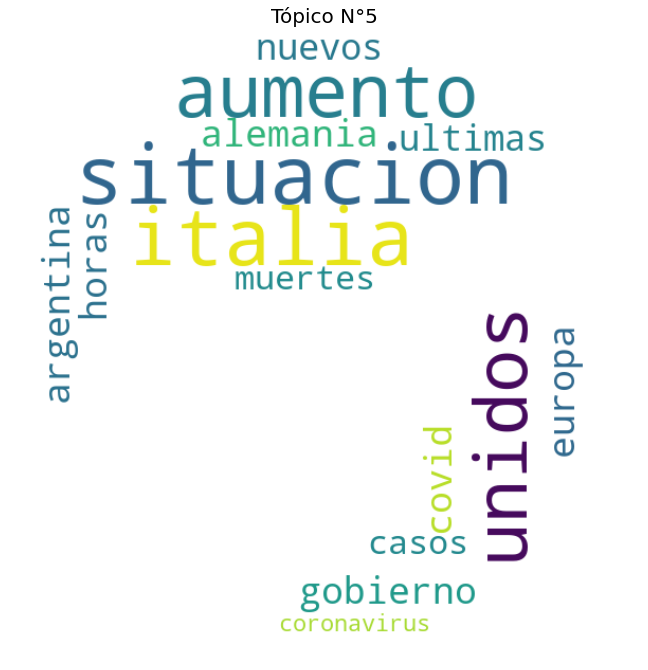

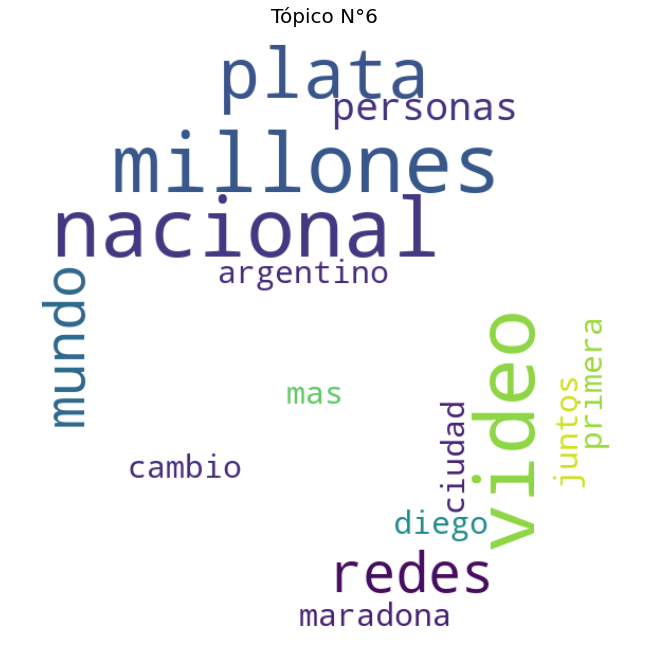

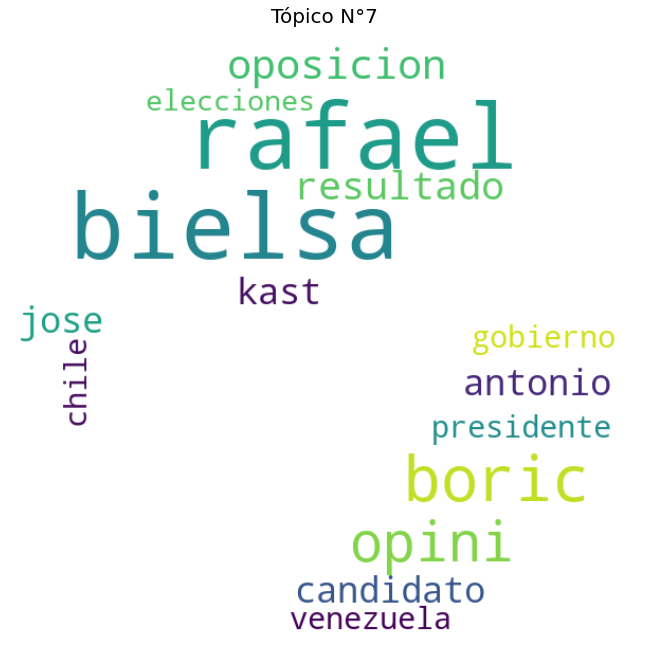

In [37]:
# Word clouds de cada tópico

mask = np.array(Image.open('Clarin.jpg')) # Creamos la máscara de imagen que vamos a usar

for index, topic in enumerate(nmf_model.components_):
    words = [tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]] # Usamos las 15 palabras más representativas
    wc = WordCloud(background_color="white", max_words=100, mask=mask, collocations=False, stopwords=stop_words)
    clean_string = ','.join(words)
    wc.generate(clean_string)
    
    f = plt.figure(figsize=(25,25))
    f.add_subplot(1,2, 2)
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f"Tópico N°{index}", fontdict={'fontsize': 20})
    plt.axis("off")